In [67]:
# !pip install yfinance torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from collections import deque
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo: {device}")

np.random.seed(42)
torch.manual_seed(42)

Dispositivo: cuda


In [71]:
# =============================================================================
# 1. DESCARGA Y PREPARACIÓN DE DATOS
# =============================================================================

print("\nDescargando datos...")
# Descarga datos históricos de Apple (AAPL) desde 2020 hasta 2024
data = yf.download('AAPL', '2020-01-01', '2024-12-31')
# Elimina el nivel superior de columnas multi-índice que crea yfinance
data.columns = data.columns.droplevel(1)

# Cálculo de características técnicas para el trading:
# - Returns: Retornos diarios (cambio porcentual día a día)
data['Returns'] = data['Close'].pct_change()
# - SMA_13: Media móvil simple de 13 días (tendencia a medio plazo)
data['SMA_13'] = data['Close'].rolling(13).mean()
# - SMA_5: Media móvil simple de 5 días (tendencia a corto plazo)
data['SMA_5'] = data['Close'].rolling(5).mean()
# - Trading_Signal: Señal binaria (1 si SMA_13 > SMA_5, indicando tendencia alcista)
data['Trading_Signal'] = np.where(data['SMA_13'] > data['SMA_5'], 1, 0)

# Elimina filas con valores NaN (generados por las medias móviles)
data.dropna(inplace=True)

# División de datos: 80% para entrenamiento, 20% para pruebas
split_ratio = 0.8
split_index = int(split_ratio * len(data))

train = data[:split_index]  # Datos de entrenamiento
test = data[split_index:]   # Datos de prueba

# =============================================================================
# 2. DEFINICIÓN DEL ENTORNO DE TRADING
# =============================================================================

class TradingEnv:
    """
    Entorno de trading que simula la operación de acciones.
    Permite al agente realizar acciones de compra, venta o mantener posiciones.
    """

    def __init__(self, df, init_bal=10000):
        """
        Inicializa el entorno de trading.

        Args:
            df: DataFrame con datos históricos de precios
            init_bal: Balance inicial en efectivo (por defecto $10,000)
        """
        self.df = df
        self.init_bal = init_bal
        self.reset()

    def reset(self):
        """
        Reinicia el entorno al estado inicial.

        Returns:
            Estado inicial del entorno (observación)
        """
        self.step_idx = 0                    # Índice del paso actual
        self.balance = self.init_bal         # Efectivo disponible
        self.shares = 0                      # Número de acciones poseídas
        self.net = self.init_bal            # Valor neto total (efectivo + acciones)
        return self._obs()

    def _obs(self):
        """
        Genera la observación del estado actual del entorno.

        Returns:
            Array numpy con 5 características:
            - Retorno del día actual
            - Media móvil de 13 días
            - Media móvil de 5 días
            - Balance normalizado (como fracción del balance inicial)
            - Valor de acciones normalizado (como fracción del balance inicial)
        """
        row = self.df.iloc[self.step_idx]
        return np.array([
            row['Returns'],                                    # Retorno diario
            row['SMA_13'],                                     # Media móvil 13 días
            row['SMA_5'],                                      # Media móvil 5 días
            self.balance / self.init_bal,                      # Balance normalizado
            (self.shares * row['Close']) / self.init_bal       # Valor acciones normalizado
        ], dtype=np.float32)

    def step(self, act):
        """
        Ejecuta una acción en el entorno.

        Args:
            act: Acción a ejecutar (0=comprar, 1=mantener, 2=vender)

        Returns:
            tuple: (nueva_observación, recompensa, terminado, info)
        """
        price = self.df.iloc[self.step_idx]['Close']

        # Lógica de acciones:
        # Acción 0: COMPRAR - solo si hay efectivo suficiente
        if act == 0 and self.balance > price:
            self.shares = self.balance // price      # Compra todas las acciones posibles
            self.balance -= self.shares * price      # Resta el costo de la compra

        # Acción 2: VENDER - solo si tiene acciones
        elif act == 2 and self.shares:
            self.balance += self.shares * price      # Suma el dinero de la venta
            self.shares = 0                          # Ya no tiene acciones

        # Acción 1: MANTENER - no hace nada (implícito)

        # Avanza al siguiente paso
        self.step_idx += 1

        # Calcula el valor neto actual
        self.net = self.balance + self.shares * price

        # Determina si el episodio terminó
        done = self.step_idx >= len(self.df)-1

        # Recompensa: solo se da al final del episodio (retorno porcentual)
        reward = (self.net - self.init_bal) / self.init_bal * 100 if done else 0

        return self._obs(), reward, done, {}

# =============================================================================
# 3. DEFINICIÓN DE LA RED NEURONAL DQN
# =============================================================================

class DQN(nn.Module):
    """
    Red Neuronal Profunda Q-Network para aproximar la función Q(s,a).
    Predice el valor Q para cada acción posible dado un estado.
    """

    def __init__(self, inp, out=3):
        """
        Inicializa la red neuronal.

        Args:
            inp: Número de características de entrada (dimensión del estado)
            out: Número de acciones posibles (por defecto 3: comprar, mantener, vender)
        """
        super().__init__()
        # Arquitectura de la red: 3 capas densas con activación ReLU
        self.fc = nn.Sequential(
            nn.Linear(inp, 128),    # Capa de entrada: inp -> 128 neuronas
            nn.ReLU(),              # Función de activación ReLU
            nn.Linear(128, 64),     # Capa oculta: 128 -> 64 neuronas
            nn.ReLU(),              # Función de activación ReLU
            nn.Linear(64, out)      # Capa de salida: 64 -> out acciones
        )

    def forward(self, x):
        """
        Propagación hacia adelante.

        Args:
            x: Tensor de entrada (estado)

        Returns:
            Valores Q para cada acción
        """
        return self.fc(x)

# =============================================================================
# 4. DEFINICIÓN DEL AGENTE DQN
# =============================================================================

class Agent:
    """
    Agente que implementa el algoritmo Deep Q-Network (DQN).
    Aprende a tomar decisiones de trading mediante reinforcement learning.
    """

    def __init__(self, s):
        """
        Inicializa el agente DQN.

        Args:
            s: Dimensión del espacio de estados
        """
        # Red principal (Q-network) - se entrena constantemente
        self.q = DQN(s).to(device)
        # Red objetivo (Target network) - se actualiza periódicamente para estabilidad
        self.t = DQN(s).to(device)
        # Optimizador Adam para entrenar la red principal
        self.opt = optim.Adam(self.q.parameters(), lr=1e-3)
        # Memoria de experiencias (Experience Replay Buffer)
        self.mem = deque(maxlen=1000)
        # Epsilon para exploración (empieza en 1.0 = 100% exploración)
        self.eps = 1.0

    def act(self, s):
        """
        Selecciona una acción usando estrategia epsilon-greedy.

        Args:
            s: Estado actual del entorno

        Returns:
            Acción seleccionada (0, 1, o 2)
        """
        # Exploración: acción aleatoria con probabilidad epsilon
        if random.random() < self.eps:
            return random.randrange(3)

        # Explotación: acción que maximiza el valor Q
        qs = self.q(torch.FloatTensor(s).to(device)).cpu()
        return qs.argmax().item()

    def mem_and_learn(self, s, a, r, ns, d):
        """
        Almacena experiencia en memoria y entrena la red si hay suficientes ejemplos.

        Args:
            s: Estado actual
            a: Acción tomada
            r: Recompensa recibida
            ns: Nuevo estado
            d: Bandera de episodio terminado
        """
        # Almacena la experiencia (s, a, r, s', done) en memoria
        self.mem.append((s, a, r, ns, d))

        # Solo entrena si hay suficientes experiencias (batch size = 32)
        if len(self.mem) < 32:
            return

        # Muestrea un batch aleatorio de experiencias
        batch = random.sample(self.mem, 32)
        s, a, r, ns, d = zip(*batch)

        # Convierte a tensores de PyTorch
        s = torch.FloatTensor(s).to(device)
        a = torch.LongTensor(a).unsqueeze(1).to(device)
        r = torch.FloatTensor(r).to(device)
        ns = torch.FloatTensor(ns).to(device)
        d = torch.BoolTensor(d).to(device)

        # Calcula valores Q actuales para las acciones tomadas
        q = self.q(s).gather(1, a).squeeze()

        # Calcula valores Q máximos para los siguientes estados (usando red objetivo)
        nq = self.t(ns).max(1)[0].detach()

        # Calcula objetivos Q usando ecuación de Bellman
        # Q(s,a) = r + γ * max_a' Q(s',a') donde γ = 0.95 (factor de descuento)
        tgt = r + 0.95 * nq * (~d)

        # Calcula pérdida (Mean Squared Error)
        loss = F.mse_loss(q, tgt)

        # Backpropagation y actualización de parámetros
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()

        # Decaimiento de epsilon (reduce exploración gradualmente)
        self.eps = max(0.01, self.eps * 0.995)

    def update(self):
        """
        Actualiza la red objetivo copiando pesos de la red principal.
        Esto mejora la estabilidad del entrenamiento.
        """
        self.t.load_state_dict(self.q.state_dict())

# =============================================================================
# 5. ENTRENAMIENTO DEL AGENTE
# =============================================================================

# Crea el entorno de entrenamiento
env = TradingEnv(train)
# Obtiene el tamaño del espacio de estados
st_size = len(env.reset())
# Crea el agente DQN
agent = Agent(st_size)

# Bucle de entrenamiento: 50 episodios
for ep in range(50):
    # Reinicia el entorno para cada episodio
    s = env.reset()
    done = False

    # Ejecuta pasos hasta que el episodio termine
    while not done:
        # Selecciona una acción
        a = agent.act(s)
        # Ejecuta la acción en el entorno
        ns, r, done, _ = env.step(a)
        # Almacena experiencia y entrena
        agent.mem_and_learn(s, a, r, ns, done)
        # Actualiza estado actual
        s = ns

        # Actualiza red objetivo cada 10 episodios
        if ep % 10 == 0:
            agent.update()

print("Entrenamiento finalizado")

# =============================================================================
# 6. BACKTEST Y EVALUACIÓN
# =============================================================================

# Crea entorno de prueba con datos no vistos durante entrenamiento
env = TradingEnv(test)
# Desactiva exploración (epsilon = 0) para usar solo conocimiento aprendido
agent.eps = 0
# Lista para almacenar el valor neto en cada paso
vals = []

# Ejecuta el agente entrenado en datos de prueba
for _ in range(len(test)):
    # Reinicia solo en el primer paso
    s = env.reset() if _ == 0 else s
    # Selecciona acción (solo explotación, sin exploración)
    a = agent.act(s)
    # Ejecuta acción y obtiene nuevo estado
    s, _, done, _ = env.step(a)
    # Almacena valor neto actual para análisis posterior
    vals.append(env.net)
    # Termina si el episodio acabó
    if done:
        break


Descargando datos...


[*********************100%***********************]  1 of 1 completed


Entrenamiento finalizado



=== BACKTESTING ===
Retorno Q-Learning: 40.91%
Retorno Buy & Hold: 39.32%
Diferencia: 1.59%


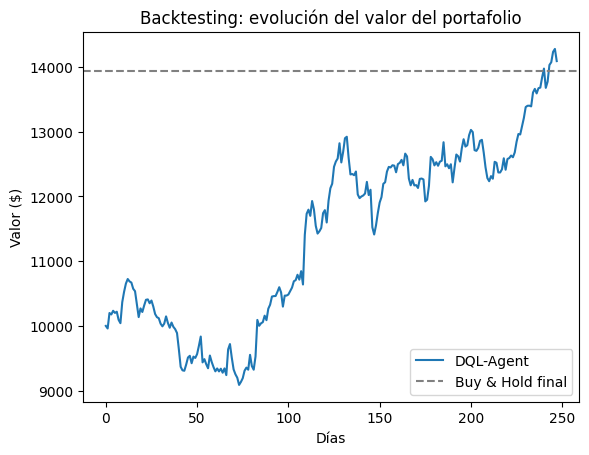

In [72]:
# Buy & Hold
bh = (test['Close'].iloc[-1]/test['Close'].iloc[0])*10000

backtest_return = (vals[-1]/vals[0]-1) * 100
buy_hold_return = (bh/10000-1) * 100

# Mostrar resultados finales
print("\n=== BACKTESTING ===")
print(f"Retorno Q-Learning: {backtest_return:.2f}%")
print(f"Retorno Buy & Hold: {buy_hold_return:.2f}%")
print(f"Diferencia: {backtest_return - buy_hold_return:.2f}%")

# Graficar evolución del portafolio en backtest
plt.plot(vals, label="DQL-Agent")
plt.axhline(bh, color='gray', linestyle='--', label="Buy & Hold final")
plt.title("Backtesting: evolución del valor del portafolio")
plt.xlabel("Días")
plt.ylabel("Valor ($)")
plt.legend()
plt.show()

In [73]:
torch.save(agent.q.state_dict(), "dql_model.pth")

In [75]:
state_size = 5  # debe ser el mismo número de features
loaded_model = DQN(state_size)
loaded_model.load_state_dict(torch.load("dql_model.pth"))
loaded_model.to(device)
loaded_model.eval()

DQN(
  (fc): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=3, bias=True)
  )
)